# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import sklearn
from sklearn import linear_model, model_selection, ensemble, metrics
import torch
from torch import nn, optim
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preview Data

In [2]:
# import data
fraudDF = pd.read_csv("Fraud_Data.csv")
mapDF = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
# preview fraud data
fraudDF.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
# preview ip address data
mapDF.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# Prepare Data
- separate targets (class) from data
- reformat signup_time & purchase_time columns to floats

In [5]:
# check the ratio of unique values in 'user_id' & 'device_id'
for key in ['user_id', 'device_id']:
    print(f"{key}: \t ratio of unique values to total values \t {fraudDF[key].unique().shape[0]/fraudDF.shape[0]:0.4f}")

user_id: 	 ratio of unique values to total values 	 1.0000
device_id: 	 ratio of unique values to total values 	 0.9129


In [6]:
# pull out the target
target = fraudDF.pop('class')

In [7]:
# convert 'signup_time' & 'purchase_time' --> datetime --> int
for key in ['signup_time', 'purchase_time']:
    fraudDF[key] = (pd.to_datetime(fraudDF[key]).astype(int) / 1e9).astype(np.int64)

# Engineer Features
- get the number of times the device id in the observations shows up in the entire dataset
- create a column showing the time difference, in seconds, between when the account was created and when purchase was made
- get the country of the IP address

In [8]:
# get the number of times the device id in the observations shows up in the entire dataset
fraudDF['device_id_counts'] = fraudDF.groupby('device_id')['device_id'].transform('count')

In [9]:
# create a column showing the time difference, in seconds, between when the account was created and when purchase was made
fraudDF['dt_seconds'] = (fraudDF.purchase_time - fraudDF.signup_time).astype(np.int64)

In [10]:
# create empty column to hold country values
fraudDF['country'] = np.empty(fraudDF.shape[0], dtype='O')

# fill in the country where the ip address originates
t0 = datetime.now()
for i in tqdm(range(mapDF.shape[0])):
    row = mapDF.iloc[i]
    fraudDF.loc[ 
        (fraudDF.ip_address >= row.lower_bound_ip_address) & 
        (fraudDF.ip_address <= row.upper_bound_ip_address),
        'country'
    ] = row.country
dt = datetime.now() - t0
print(f"Elapsed Time: \t {dt.total_seconds()/60} minutes")


Elapsed Time: 	 19.2664445 minutes


# Finish Preparing Data
- drop: user_id, device_id, ip_address
- one-hot encode columns: source, browser, sex, country
- combine countries where there are <= 100 ip address in the data set
- remove columns

In [11]:
# remove 'user_id', 'device_id', and 'ip_address' from the fraud dataframe
fraudDF.drop(columns=['user_id', 'device_id', 'ip_address'], inplace=True)

In [12]:
# one-hot encode discrete class based data
fraudDF = pd.get_dummies(fraudDF, dummy_na=True)

In [13]:
# if there are no nans, delete the columns
for cat in ['source', 'browser', 'sex', 'country']:
    total = fraudDF[cat+'_nan'].sum()
    print(f"{cat} nans: \t {total}")
    if total == 0: fraudDF.drop(cat+'_nan', axis=1, inplace=True)

source nans: 	 0
browser nans: 	 0
sex nans: 	 0
country nans: 	 21966


In [14]:
# find a DF of small countries
smallDF = fraudDF[[key for key in fraudDF.keys() if ('country' in key) & (fraudDF[key].sum() < 200)]]

# add a column that holds one-hotted values for countries with few ip addresses in the data set
fraudDF['country_few'] = smallDF.sum(axis=1)

# # remove all the columns in smallDF from fraudDF
# fraudDF1 = fraudDF.drop(columns=smallDF.keys())

# Feature Importance

In [15]:
# create an ensemble to find out the feature importance
forest = ensemble.ExtraTreesClassifier(
    n_estimators=250,
    random_state=0
)

# fit the ensemble
forest.fit(fraudDF, target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
# store the features importances and their labels in DataFrame
features = pd.DataFrame({
    'importance' : forest.feature_importances_,
    'labels'     : fraudDF.keys()
})

# sort values by feature importance
features.sort_values('importance', inplace=True)

# only select values where feature > 1e-3
features = features[ features.importance > 1e-3 ]

<BarContainer object of 28 artists>

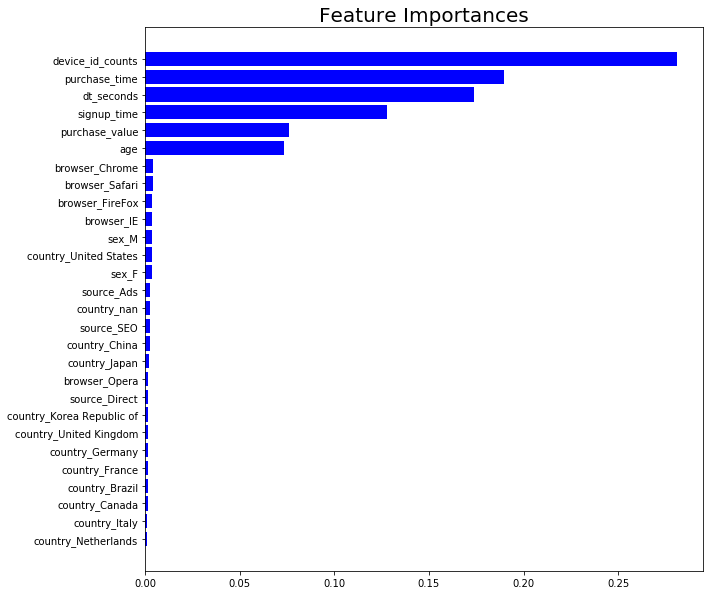

In [17]:
# plot the feature importance
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Feature Importances", fontsize=20)
ax.barh(
    range(features.shape[0]),
    features.importance,
    color = "b",
    align = "center",
    tick_label = features.labels
)

In [19]:
# preview Features
features.head(10)

,importance,labels
134,0.001022,country_Netherlands
98,0.001134,country_Italy
48,0.001235,country_Canada
40,0.001296,country_Brazil
76,0.001373,country_France
80,0.001388,country_Germany
186,0.001585,country_United Kingdom
104,0.001593,country_Korea Republic of
7,0.001685,source_Direct
12,0.001699,browser_Opera


In [20]:
# save another edition of fraudDF, with only the important features
DF = fraudDF[[ key for key in features.sort_values('importance', ascending=False).labels ]]

# Split Data Into Training and Test Sets

In [31]:
# split data into train and test sets
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(DF, target, test_size=0.1)

In [32]:
# make sure that the ratio of true:total is similar in both sets
for x in [ytrain, ytest]:
    print(f"target ratio: \t {x.sum() / x.shape[0]:0.4f}")

target ratio: 	 0.0938
target ratio: 	 0.0926


# Cross Validation / Model Selection Function

In [23]:
def random_search(estimator, params, n_iter=30, cv=3, iid=False, scoring='roc_auc', return_train_score=True):
    """
    returns sklearn.model_selection.RandomizedSearchCV instance.
    
    positional arguments:
        estimator: instance of an sklearn model
        params: dict - hyperparameter distributions available
    
    keyword arguments:
        n_iter: int - the number of iterations to try - default = 30
        cv: int - the number of k-folds to use - default = 3
        iid: bool - independent and identically distributed - default = False
        scoring: str - the performance metric used for tuning the model - default = 'recall'
        return_train_score: bool - whether the training score is included in cv_results_ - default = True
    """
    search = model_selection.RandomizedSearchCV(
        estimator,
        param_distributions = params,
        n_iter = n_iter,
        cv = cv,
        iid = iid,
        refit = True,
        scoring = scoring
    )
    return search

def organize_scores(inst, round_to=5):
    """
    returns a pd.DataFrame instance where all the scores are organized in a set of tuples that contain
    the train and test scores for each split in the k-fold, for each iteration.
    
    positional argument:
        inst: sklearn.model_selection.RandomizedSearchCV - fitted
    
    keyword argument:
        round_to: int - the decimal place to report for the scores
    """
    scores = {key:value for key,value in inst.cv_results_.items() if 'split' in key}
    scores1 = {}
    for i in range(inst.cv):
        scores1[f"split_{i}"] = [ (train.round(round_to),test.round(round_to)) for train,test in zip(scores[f"split{i}_train_score"], scores[f"split{i}_test_score"]) ]
    return pd.DataFrame(scores1)

def report(inst, validation=True, test=True):
    """
    prints the best set of parameters and the best score from the k-folds cross validation
    performed on the training set.
    
    prints major performance metrics made against the test set (test set is not used during hyperparameter
    tuning.)
    
    positional argument:
        inst: sklearn.model_selection.RandomizedSearchCV - fitted
    
    keyword arguments:
        validation: bool - whether to print k-folds results
        test: bool - wheter to print test results and retrurn results as dict
    """
    
    if validation:
        print("\nbest parameters for train-validate k-folds:")
        for key,val in inst.best_params_.items():
            print(f"{key} \t {val}")
            
        print("\n",organize_scores(inst))
        
    print(f"\nbest test score: \t {inst.best_score_}")
    
    if test:
        print("\nPerformance Metrics on Test Set")
        yhat = inst.predict(Xtest)
        results = {
            'params'           : inst.best_params_,
            'yhat'             : yhat,
            'accuracy'         : metrics.accuracy_score(ytest, yhat),
            'confusion matrix' : metrics.confusion_matrix(ytest, yhat),
            'precision'        : metrics.precision_score(ytest, yhat),
            'recall'           : metrics.recall_score(ytest, yhat),
            'ROC-AUC'          : metrics.roc_auc_score(ytest, yhat),
            'F1'               : metrics.f1_score(ytest, yhat)
        }

        for key,val in results.items(): 
            if key != 'params': print(f"\n{key}: \n{val}")

        return results

def roc_auc_curve(inst, X=Xtest, y=ytest):
    """
    plots the ROC-AUC
    
    positional argument:
        inst: sklearn.model_selection.RandomizedSearchCV - fitted
    
    keyword arguments:
        X: pd.DataFrame - features
        y: pd.Series - targets
    """
    
    # false positive rate, true positive rate, threshold
    fpr, tpr, t = metrics.roc_curve(y, inst.predict_proba(X)[:,1])
    
    # get the area under the curve
    auc = metrics.roc_auc_score(y, inst.predict(X))
    
    # construct figure
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic-Area Under the Curve", fontsize=20)
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.plot(fpr, tpr, linewidth=4, label='ROC curve')
    
    plt.fill_between(
        fpr,
        0,
        y2 = tpr,
        color = 'r',
        label = f"AUC: {auc:0.4f}"
    )
    
    plt.legend(loc=2, fontsize=20)
    
def plot_confusion_matrix(results, **kwargs):
    """
    plots the confusion matrix
    
    positional argument:
        results: dict - the output of report(*args, test=True)
    """
    
    # alias confusion matrix
    cm = results['confusion matrix']
    
    # normalize the columns
    cm = cm / cm.sum(axis=1, keepdims=True)
    
    # construc figure
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title("Confusion Matrix, Rows Normalized", fontsize=20)
    sns.heatmap(cm, annot=True, **kwargs)
    ax.set_xlabel("Predicted", fontsize=20)
    ax.set_ylabel("Actual", fontsize=20)

# Random Forest Model

In [24]:
# set up random forest
rf = ensemble.RandomForestClassifier(
    bootstrap = True,
    criterion = 'entropy'
)

In [25]:
# set up the parameter dictionary
rf_params = {
    'n_estimators'      : (2**np.linspace(0, 10, 11)).astype(np.int32),
    'max_features'      : np.linspace(.1, 1, 10),
    # 'criterion'         : ['gini', 'entropy'],
    'max_depth'         : np.arange(2, 9),
    'min_samples_split' : 2**np.arange(4, 11),
    # 'bootstrap'         : [True, False],
}

In [33]:
# create RandomizedSearchCV instance for random forest estimator
rf_search = random_search(rf, rf_params, n_iter=20, scoring='roc_auc')

In [34]:
# train random forests
t0 = datetime.now()
rf_search.fit(Xtrain, ytrain)
dt = datetime.now() - t0
print(f"\nelapsed time for random search: \t {dt.total_seconds()/60:0.4f} minutes")


elapsed time for random search: 	 34.5878 minutes


In [35]:
# print major performance metrics
rf_results = report(rf_search)


best parameters for train-validate k-folds:
n_estimators 	 32
min_samples_split 	 256
max_features 	 0.9
max_depth 	 5

                split_0             split_1             split_2
0   (0.84468, 0.84514)  (0.84543, 0.84347)  (0.84623, 0.84525)
1   (0.85267, 0.84622)   (0.85289, 0.8445)  (0.85286, 0.84263)
2   (0.87229, 0.84374)   (0.8728, 0.84462)  (0.87409, 0.84274)
3   (0.88936, 0.84401)    (0.886, 0.84539)  (0.88912, 0.84013)
4    (0.78942, 0.7855)  (0.76273, 0.75507)  (0.82856, 0.82305)
5   (0.78941, 0.78167)  (0.84697, 0.84434)  (0.84635, 0.83924)
6   (0.85271, 0.84616)  (0.85421, 0.84449)  (0.85464, 0.84137)
7    (0.8495, 0.84608)  (0.84934, 0.84543)    (0.85342, 0.843)
8   (0.84779, 0.84093)  (0.85575, 0.84296)  (0.84419, 0.83493)
9   (0.86261, 0.84453)  (0.86266, 0.84478)  (0.86142, 0.84026)
10   (0.84659, 0.8439)  (0.84838, 0.84337)  (0.84802, 0.84442)
11  (0.87125, 0.84547)   (0.87321, 0.8474)  (0.87773, 0.84364)
12  (0.85916, 0.84633)  (0.86185, 0.84535)  (0.86505, 0.842

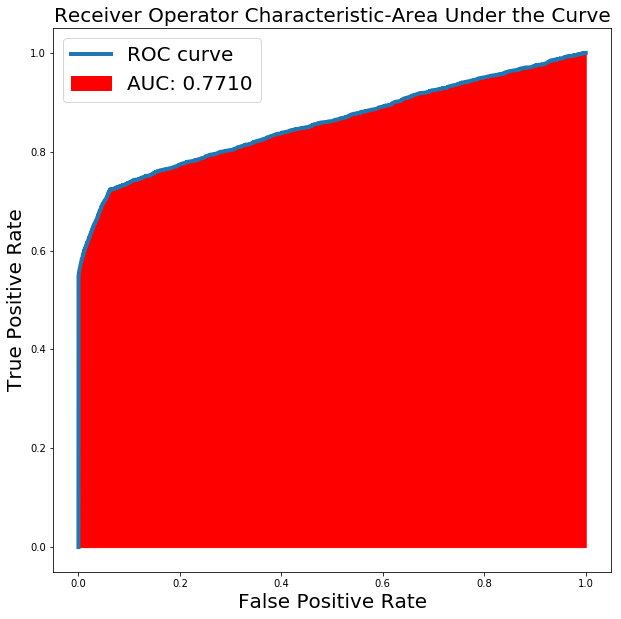

In [36]:
# plot the ROC-AUC of the test set
roc_auc_curve(rf_search)

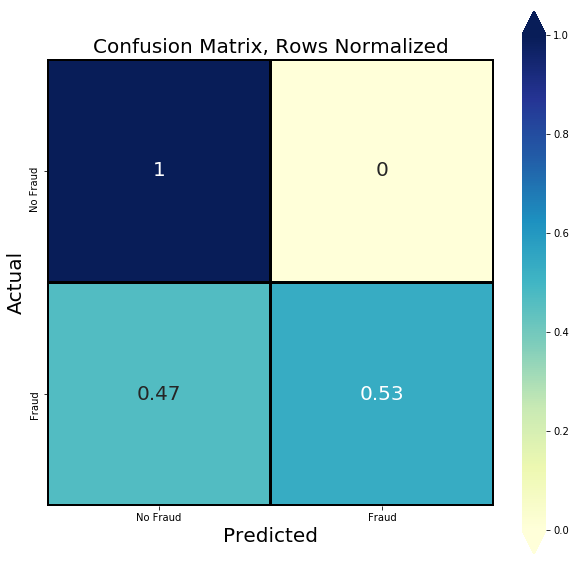

In [37]:
plot_confusion_matrix(
    rf_results,
    xticklabels = ['No Fraud', 'Fraud'],
    yticklabels = ['No Fraud', 'Fraud'],
    cmap = 'YlGnBu',
    square = True,
    annot_kws = {"size": 20},
    cbar_kws = {'extend': 'both'},
    linecolor = 'k',
    linewidth = 2
)